In [1]:
import boto3
import argparse

In [2]:
# # Optional: Set AWS credentials
# # To use this cell, comment out all lines

# # Alternatively, if your AWS credential is defined in ~/.aws/credentials
# # you can use `profile_name` parameter in submit_job() function

# import os, getpass
# os.environ["AWS_ACCESS_KEY_ID"] = getpass.getpass("Enter aws access key ID ")
# os.environ["AWS_SECRET_ACCESS_KEY"] = getpass.getpass("Enter aws secret access key ")
# os.environ["AWS_DEFAULT_REGION"] = input("Enter aws default region ")

In [3]:
def submit_job(lr:float, momentum:float, epochs:int, profile_name=None):
    """
    Submit a job to AWS Batch queue.
    Parameters
    ----------
    lr: float
        Learning rate
    momentum: float
    epochs: float
        Maximum number of training epochs
    profile_name: str
        The profile name used to access AWS.
        The profile is defined in `~/.aws/credentials`.
    """
    if profile_name is None:
        session = boto3.Session()
    else:
        session = boto3.Session(profile_name=profile_name)
    client = session.client("batch")
    
    title = "lr" + str(lr).replace(".", "") + "_m" + str(momentum).replace(".", "")
    resp = client.submit_job(
        jobName=title,
        jobQueue="SimpleBatchjob-queue",
        jobDefinition="SimpleBatchjob-definition",
        containerOverrides={
            "command": ["--lr", str(lr),
                        "--momentum", str(momentum),
                        "--epochs", str(epochs),
                        "--uploadS3", "true"]
        }
    )
    print("Job submitted!")
    print("job name", resp["jobName"], "job ID", resp["jobId"])

### Let's run many tasks in parallel

In [4]:
for lr in [0.1, 0.01, 0.001]:
    for m in [0.5, 0.1, 0.05]:
        submit_job(lr, m, 100)

Job submitted!
job name lr01_m05 job ID f4fedeec-afb4-4bfb-9ac4-7634122891a7
Job submitted!
job name lr01_m01 job ID 6f7571ce-e491-464f-b3a0-7f5cdd01019c
Job submitted!
job name lr01_m005 job ID def39095-20dd-41f4-8633-c752941c287f
Job submitted!
job name lr001_m05 job ID d197260b-846f-4744-ade3-114b441f68c3
Job submitted!
job name lr001_m01 job ID 061fae34-8475-4f5c-970d-89ca52277463
Job submitted!
job name lr001_m005 job ID 30f439ea-414c-4c95-af69-5d7ba81a9310
Job submitted!
job name lr0001_m05 job ID b6cd1a40-80aa-477f-9b35-43552196f5ad
Job submitted!
job name lr0001_m01 job ID 51337c84-ff5c-44ee-8e95-43ad83b51005
Job submitted!
job name lr0001_m005 job ID d6f7846b-8224-46bf-b1cd-16e3464eb1d8


### Let's download the learning result and make plots

In [5]:
import pandas as pd
import numpy as np
import io
from matplotlib import pyplot as plt

In [6]:
def read_table_from_s3(bucket_name, key, profile_name=None):
    if profile_name is None:
        session = boto3.Session()
    else:
        session = boto3.Session(profile_name=profile_name)
    s3 = session.resource("s3")
    bucket = s3.Bucket(bucket_name)
    
    obj = bucket.Object(key).get().get("Body")
    df = pd.read_csv(obj)
    
    return df

In [8]:
#### Remember to replace bucket name with your own name! ####
bucket_name = "simplebatch-bucket43879c71-mbqaltx441fu"

grid = np.zeros((3,3))
for (i, lr) in enumerate([0.1, 0.01, 0.001]):
    for (j, m) in enumerate([0.5, 0.1, 0.05]):
        key = f"metrics_lr{lr:0.4f}_m{m:0.4f}.csv"
        df = read_table_from_s3(bucket_name, key)
        grid[i,j] = df["val_accuracy"].max()

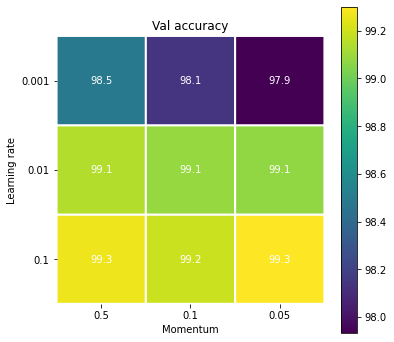

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

c = ax.pcolor(grid, edgecolors='w', linewidths=2)

for i in range(3):
    for j in range(3):
        text = ax.text(j+0.5, i+0.5, f"{grid[i, j]:0.1f}",
                       ha="center", va="center", color="w")

ax.set_title("Val accuracy")
ax.set_xticks([0.5,1.5,2.5])
ax.set_xticklabels([0.5, 0.1, 0.05])
ax.set_xlabel("Momentum")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels([0.1, 0.01, 0.001])
ax.set_ylabel("Learning rate")

ax.set_frame_on(False)
fig.colorbar(c, ax=ax)